# Proyecto

Se tiene una cartera de 1200 personas que fueron empleados del Banco de Colombia. Dentro de los beneficios de trabajar en dicha compañía, a cada de uno de ellos se les asignó una renta vitalicia reversible, es decir, que, si el titular de la renta fallece, la renta se transfiere a su cónyuge. 
Realice la valoración para cada persona para obtener el importe total por compromiso de todas las rentas vitalicias que tiene con todos los asegurados. Es decir, cuánto me cuesta esta persona. Valor total al final. 

Propuesta de Banco de Colombia: Cambiar la renta vitalicia por un monto establecido hoy. 
Cuál es el porcentaje mínimo de tasa de aceptación para que el proyecto sea viable si Banco de Colombia quiere ahorrar al menos un 30% del valor total de la cartera. 

In [1]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:,.2f}'.format
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys 
import os
sys.path.append(os.path.abspath('../src'))

from Tablas_mortalidad import *

In [3]:
Tmort_h = pd.read_excel('../src/TM_hombres.xlsx' )
Tmort_m = pd.read_excel('../src/TM_mujeres.xlsx' )

In [4]:
T_hombre=TMensual(Tmort_h)
T_mujer=TMensual(Tmort_m)

In [5]:
datos = pd.read_excel('../src/datos_longevidad.xlsx', sheet_name='Data')

In [6]:
v_jubilado=[]
v_pareja=[]
i=0.04/12

for index, row in datos.iterrows():
    
    genero=row['Genero']
    
    if genero=='H':
        tmort=T_hombre
    else:
        tmort=T_mujer
        
    if row['Casado']==0:
        edad=row['Edad']
        pago=row['Pago_mensual']
        T=tmort_filtered(tmort,edad)
        T['n'] = T['x'].apply(lambda x: x - edad) * 12
        T['Vn'] = np.ones(len(T)) *(1/(1+i))
        T['Vn'] = T.apply(lambda row: row['Vn'] ** row['n'], axis=1)
        sum_vect = pago * T['Vn'] * T['p(x)']
        va_jubilado = sum_vect.sum()
        va_pareja = 0

        v_jubilado.append(va_jubilado)
        v_pareja.append(va_pareja)
        
    elif row['Casado']==1:
        #Renta vitalicia Reversible
        edad=row['Edad']
        pago=row['Pago_mensual']
        T=tmort_filtered(tmort,edad)
        T['n'] = T['x'].apply(lambda x: x - edad)*12
        T['Vn'] = np.ones(len(T))*(1/(1+i))
        T['Vn'] = T.apply(lambda row: row['Vn'] ** row['n'], axis=1)
        sum_vect=pago*T['Vn']*T['p(x)']
        va_jubilado=sum_vect.sum()

        edad_pareja=row['Edad_pareja']
        genero_pareja=row['Sexo_pareja']
        
        if genero_pareja=='H':
            tmort_pareja=T_hombre
        else:
            tmort_pareja=T_mujer
            
        T_par=tmort_filtered(tmort_pareja,edad_pareja)
        T_par['n'] = T_par['x'].apply(lambda x: x - edad_pareja)*12
        T_par['Vn'] = np.ones(len(T_par))*(1/(1+i))
        T_par['Vn'] = T_par.apply(lambda row: row['Vn'] ** row['n'], axis=1)
        
        if edad<=edad_pareja:
            T_par['q(x)_Jub'] = T['q(x)'][:len(T_par)]
        else:
            lista=[]
            gap=(edad-edad_pareja)*12
            lista = list(T['q(x)'])+list(np.ones(gap))
            T_par['q(x)_Jub']=lista
            
        sum_vect_pareja=pago*T_par['Vn']*T_par['p(x)']*T_par['q(x)_Jub']
        va_pareja=sum_vect_pareja.sum()
        
        v_jubilado.append(va_jubilado)
        v_pareja.append(va_pareja)

datos['Valoracion Jubilado']=v_jubilado
datos['Valoracion pareja']=v_pareja
datos['Pago_mensual']=datos['Pago_mensual'].apply(lambda x: f'{x:,.2f}')
datos['Valoracion']=datos['Valoracion Jubilado']+datos['Valoracion pareja']
datos

,Unnamed: 0,Edad,Casado,Genero,Edad_pareja,Sexo_pareja,Pago_mensual,Valoracion Jubilado,Valoracion pareja,Valoracion
0,1,68,0,M,0,0,"4,196,583.06","1,017,456,036.16",0.00,"1,017,456,036.16"
1,2,67,1,H,67,H,"1,983,941.40","484,784,234.22","4,985,840.73","489,770,074.95"
2,3,80,1,H,77,H,"4,014,628.81","828,188,996.93","53,608,562.26","881,797,559.19"
3,4,71,1,H,85,M,"5,710,179.97","1,339,739,654.76","6,941,368.13","1,346,681,022.89"
4,5,66,0,M,0,0,"7,882,172.76","1,946,327,113.36",0.00,"1,946,327,113.36"
...,...,...,...,...,...,...,...,...,...,...
1195,1196,78,0,M,0,0,"2,994,379.20","640,482,469.74",0.00,"640,482,469.74"
1196,1197,72,1,M,69,H,"3,778,424.20","877,935,210.33","36,050,544.95","913,985,755.27"
1197,1198,76,0,M,0,0,"3,839,464.83","846,745,509.27",0.00,"846,745,509.27"
1198,1199,77,0,H,0,0,"10,827,760.94","2,348,062,669.86",0.00,"2,348,062,669.86"


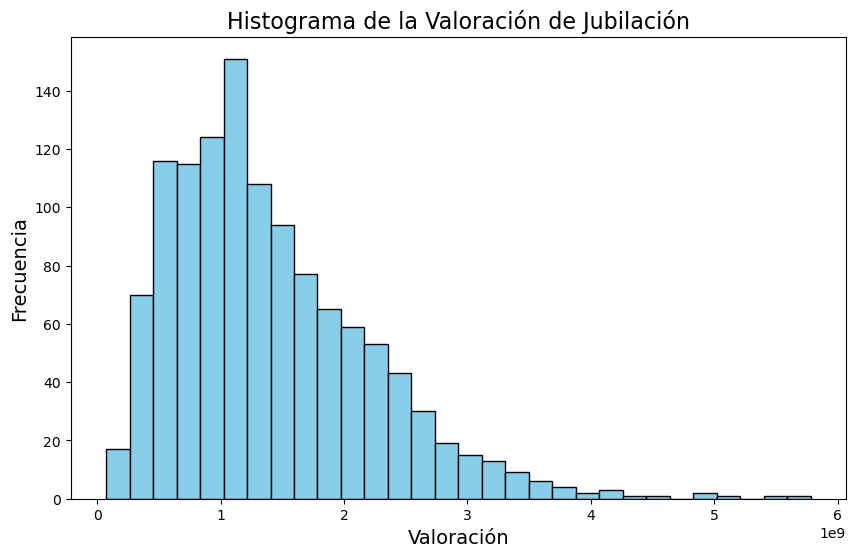

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(datos['Valoracion'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma de la Valoración de Jubilación', fontsize=16)
plt.xlabel('Valoración', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

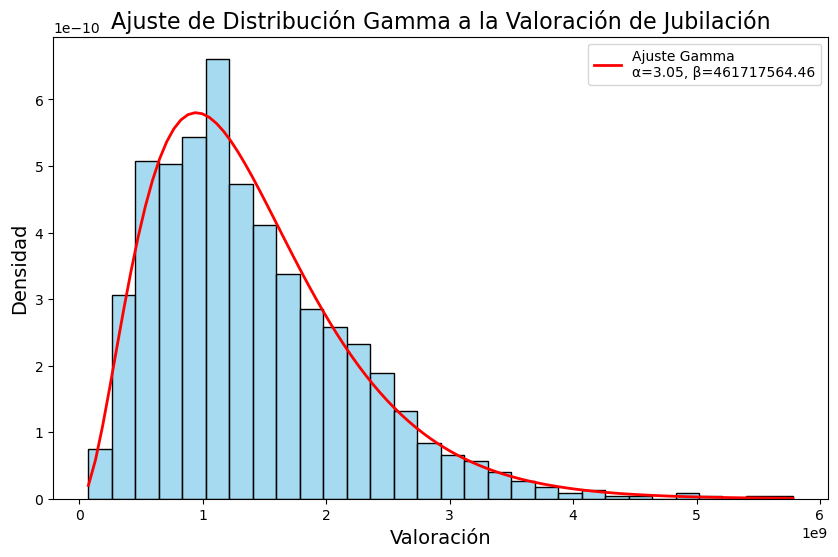

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gamma
params = gamma.fit(datos['Valoracion'], floc=0) 

xmin, xmax = datos['Valoracion'].min(), datos['Valoracion'].max()
x = np.linspace(xmin, xmax, 100)
pdf_fitted = gamma.pdf(x, *params)  
plt.figure(figsize=(10, 6))
sns.histplot(datos['Valoracion'], bins=30, kde=False, color='skyblue', stat='density', edgecolor='black')
plt.plot(x, pdf_fitted, 'r-', lw=2, label=f'Ajuste Gamma\nα={params[0]:.2f}, β={params[2]:.2f}')
plt.title('Ajuste de Distribución Gamma a la Valoración de Jubilación', fontsize=16)
plt.xlabel('Valoración', fontsize=14)
plt.ylabel('Densidad', fontsize=14)
plt.legend()
plt.show()